In [1]:
import numpy as np
from glob import glob
import os
import gc
from pathlib import Path
import yaml

from matplotlib import pyplot as plt
from cycler import cycler
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.backends.backend_pdf import PdfPages
plt.style.use('thesis')

from scipy.optimize import curve_fit
import scipy.signal as sig
from scipy import stats

plt.rcParams.update({'figure.dpi': 150})
plt.rcParams.update({'axes.prop_cycle': cycler(color=['#5994cd', '#d74164', '#4eaa76', '#d88300', '#7365cf', \
                                                      '#c85e3e', '#83a23e', '#c851b1', '#1850a1'])})

from importlib import reload
import data_processing as dp

### Look through the drive/data directory and print folder structure

In [2]:
# drive_path = '/Users/clarke/Data'
drive_path = '/Volumes/LaCie/'

sphere_date = '20260105'

base_path = f'{drive_path}/gas_collisions/pulse_calibration/sphere_{sphere_date}/'

if not os.path.exists(drive_path):
    print('Error: check that the external drive is plugged in!')

folders = glob(base_path + '*')

datasets = {}

for folder in folders:
    print(folder.split(base_path)[-1])
    all_items = glob(folder + '/*.hdf5')
    subfolders = np.unique(['_'.join(s.split('_')[:-1]) for s in all_items])
    sub_datasets = []
    for subfolder in subfolders:
        sub_datasets.append(subfolder.split(base_path)[-1].split('/')[-1])
        print('\t' + subfolder.split(base_path)[-1].split('/')[-1])
    datasets[folder.split(base_path)[-1]] = sub_datasets

20260107_p8e_4e-8mbar_d137khz_0
	20260107_dfg_p8e_200ns_10v
	20260107_dfg_p8e_200ns_12.5v
	20260107_dfg_p8e_200ns_15v
	20260107_dfg_p8e_200ns_17.5v
	20260107_dfg_p8e_200ns_2.5v
	20260107_dfg_p8e_200ns_20v
	20260107_dfg_p8e_200ns_5v
	20260107_dfg_p8e_200ns_7.5v
20260106_p8e_6e-8mbar_d137khz_0
	20260106_dfg_p8e_200ns_10v
	20260106_dfg_p8e_200ns_12.5v
	20260106_dfg_p8e_200ns_15v
	20260106_dfg_p8e_200ns_17.5v
	20260106_dfg_p8e_200ns_2.5v
	20260106_dfg_p8e_200ns_20v
	20260106_dfg_p8e_200ns_5v
	20260106_dfg_p8e_200ns_7.5v
20260106_p8e_6e-8mbar_d137khz_1
	20260106_dfg_p8e_200ns_10v
	20260106_dfg_p8e_200ns_12.5v
	20260106_dfg_p8e_200ns_15v
	20260106_dfg_p8e_200ns_17.5v
	20260106_dfg_p8e_200ns_2.5v
	20260106_dfg_p8e_200ns_20v
	20260106_dfg_p8e_200ns_5v
	20260106_dfg_p8e_200ns_7.5v
20260106_electric_calibration_6e-8mbar_0
	20260106_d_p8e_117khz_0.5vpp_lensholder1
	20260106_d_p8e_117khz_1.5vpp_lensholder1
	20260106_d_p8e_117khz_1vpp_lensholder1
	20260106_d_p8e_117khz_2vpp_lensholder1
	20260106_d_

### Specify impulse and analysis parameters

In [3]:
pulse_amps_1e = np.asarray([12, 34, 57, 80, 103, 127, 150, 174]) # impulses applied to the particle in eV/c
pulse_amps_V = np.arange(2.5, 21, 2.5) # pulse amplitudes applied to lens holder 1 in V

# t_window = 2e-3 # the window length in ms
search_window = 5e-5
fit_window = 1e-1 # time window for resonance fits
f_cutoff_high = 1e5 # upper cutoff frequency for the bandpass filter
f_cutoff_low = 2.5e4 # lower cutoff frequency for the bandpass filter
f_cutoff = [f_cutoff_low, f_cutoff_high]

config = {
    'fit_window': fit_window,
    'search_window': search_window,
    'meters_per_volt': None,
    'f_cutoff': f_cutoff,
    'apply_notch': False,
    'calibrate': True,
    'd_sphere_nm': 100.
}

### Load and process the data

In [4]:
reload(dp)

# choose which dataset to look at
dataset_ind = 0
dataset = list(datasets.keys())[dataset_ind]

# get the list of impulse amplitudes in that dataset
amp_list = np.argsort([float(d.split('v')[0].split('_')[-1]) for d in datasets[dataset]])
amp_list = np.concat(([amp_list[0]], amp_list))

pulse_amps_keV = []
impulses = []
resonance_params = []
fit_success = []
pulses = []
recon_inds = []
timestamps = []
pulse_times = []
meters_per_volt = []
impulse_rms = []

# number of files to look at for each amplitude
max_files = 25

# when plotting, only look at one file
plot = False
if plot:
    max_files = 1

# loop through all four files in that dataset in the correct order
for i, file_ind in enumerate(amp_list):
    if i == 0 and plot:
        continue
    filename = datasets[list(datasets.keys())[dataset_ind]][file_ind]
    plot_path = 'figures/' + base_path.split(drive_path)[-1] + dataset + '/' + filename \
                # if plot else None
    nd = dp.NanoDataset(base_path + dataset + '/' + filename, plot_path, verbose=True, max_files=max_files, ds_factor=10, config=config)
    nd.load_calibration_data(global_params=False, pulse_amps_1e=pulse_amps_1e, pulse_amps_V=pulse_amps_V, noise=i==0)
    impulses.append(nd.impulses.copy())
    pulse_amps_keV.append([nd.pulse_amp_keV.copy(), 0][i==0])
    resonance_params.append(nd.resonance_params.copy())
    fit_success.append(nd.fit_success.copy())
    pulses.append(nd.pulses.copy())
    recon_inds.append(nd.recon_impulse_inds.copy())
    pulse_times.append(nd.pulse_times.copy())
    timestamps.append(nd.timestamps.copy())
    meters_per_volt.append(nd.meters_per_volt.copy())
    impulse_rms.append(nd.impulse_rms.copy())

    if i == 0:
        freqs = np.copy(nd.freqs)
    del nd
    
    # if i > 0:
    #     break

min_len = min([len(i) for i in impulses])
pulse_amps_keV = np.array(pulse_amps_keV)
impulses = np.array([i[:min_len] for i in impulses])
pulses = np.array([i[:min_len] for i in pulses])
recon_inds = np.array([i[:min_len] for i in recon_inds])
resonance_params = np.array([i[:min_len] for i in resonance_params])
fit_success = np.array([i[:min_len] for i in fit_success])
pulse_times = np.array([i[:min_len] for i in pulse_times])
timestamps = np.array([i[:min_len] for i in timestamps])
meters_per_volt = np.mean(meters_per_volt)
impulse_rms = np.array([i[:min_len] for i in impulse_rms])

Loading files starting with
/Volumes/LaCie//gas_collisions/pulse_calibration/sphere_20260105/20260107_p8e_4e-8mbar_d137khz_0/20260107_dfg_p8e_200ns_2.5v
  Loading file 1...
  Calibrating volts to meters...
    Mass of the nanosphere: 		1.388e-18 kg
    Number of charges on the sphere: 	8
    Electric field per volt applied: 	79.0 V/m
    Trap resonant frequency: 		48.5 kHz
    Drive signal from demodulation: 	0.498 V
    Applied force from demodulation: 	5.047e-17 N
    Sensor response from demodulation: 	2.800e-04 V
    Susceptibility at 137.0 kHz drive: 	1.112e+06 m/V
    Nanosphere response amplitude: 	5.612e-11 m
    Position calibration factor: 	2.006e-07 m/V
    -> Computing impulse for kick at t=0.16558 seconds...
    -> Computing impulse for kick at t=0.46557 seconds...
    -> Computing impulse for kick at t=0.76557 seconds...
    -> Computing impulse for kick at t=1.06556 seconds...
    -> Computing impulse for kick at t=1.36556 seconds...
    -> Computing impulse for kick at 

### Mask the data based on noise and fit convergence

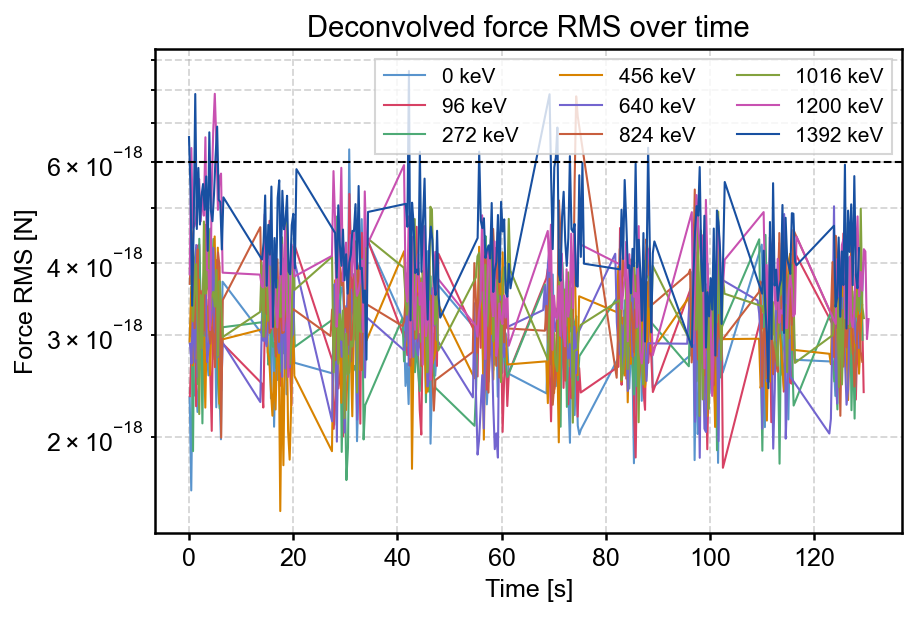

In [5]:
rms_cut = 6e-18 # cut on RMS noise in Newtons
rms_mask = impulse_rms < rms_cut

# create a mask that includes the noise and the fit convergence
mask = rms_mask & fit_success

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')

for i in range(impulse_rms.shape[0]):
    ax.plot(pulse_times[i], np.abs(impulse_rms[i]), label='{:.0f} keV'.format(pulse_amps_keV[i]))

ax.set_xlabel('Time [s]')
ax.set_ylabel('Force RMS [N]')
ax.set_yscale('log')
ax.axhline(rms_cut, ls='--', color='k')
ax.legend(ncol=3, fontsize=10)
ax.grid(which='both')
ax.set_title('Deconvolved force RMS over time')
if plot_path:
    fig.savefig(plot_path + '_rms.pdf')

### Monitor drifts in the resonance over time

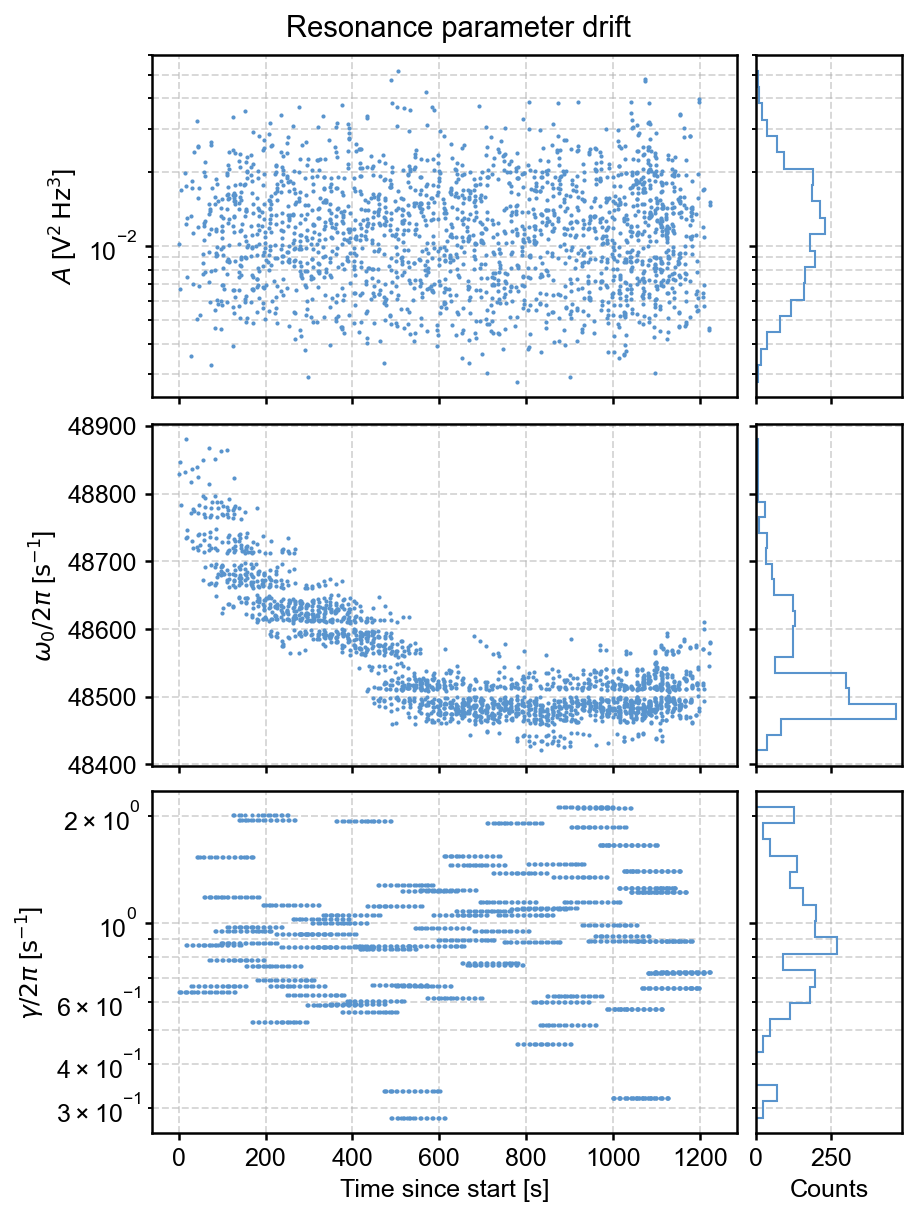

In [6]:
n_repeats = (pulse_times.shape[1] + timestamps.shape[1] - 1) // timestamps.shape[1]
pulse_timestamps = pulse_times + np.tile(timestamps, (1, n_repeats))[:, :pulse_times.shape[1]]
res_evol = np.array([resonance_params[...,i].flatten()[np.argsort(pulse_timestamps.flatten())] for i in range(3)])
res_times = np.sort(pulse_timestamps.flatten()) - np.amin(pulse_timestamps)

fig, ax = plt.subplots(3, 2, figsize=(6, 8), sharex='col', sharey='row', width_ratios=[4, 1], layout='constrained')
ax[0,0].semilogy(res_times, res_evol[0], marker='.', ms=2, ls='none')
ax[0,1].hist(res_evol[0], bins=np.logspace(np.log10(np.amin(res_evol[0])), \
             np.log10(np.amax(res_evol[0])), 20), histtype='step', orientation='horizontal')
ax[1,0].plot(res_times, res_evol[1]/2/np.pi, marker='.', ms=2, ls='none')
ax[1,1].hist(res_evol[1]/2/np.pi, bins=20, histtype='step', orientation='horizontal')
ax[2,0].semilogy(res_times, res_evol[2]/2/np.pi, marker='.', ms=2, ls='none')
ax[2,1].hist(res_evol[2]/2/np.pi, bins=np.logspace(np.log10(np.amin(res_evol[2]/2/np.pi)), \
             np.log10(np.amax(res_evol[2]/2/np.pi)), 20), \
             histtype='step', orientation='horizontal')
ax[0,0].set_ylabel(r'$A$ [$\mathrm{V^2\,Hz^3}$]')
ax[1,0].set_ylabel(r'$\omega_0/2\pi$ [$\mathrm{s}^{-1}$]')
ax[2,0].set_ylabel(r'$\gamma/2\pi$ [$\mathrm{s}^{-1}$]')
ax[2,0].set_xlabel('Time since start [s]')
ax[2,1].set_xlabel('Counts')
[ax[i, j].grid(which='both') for i in range(3) for j in range(2)]
fig.suptitle('Resonance parameter drift')
if plot_path:
    fig.savefig(plot_path + '_res_evol.pdf')

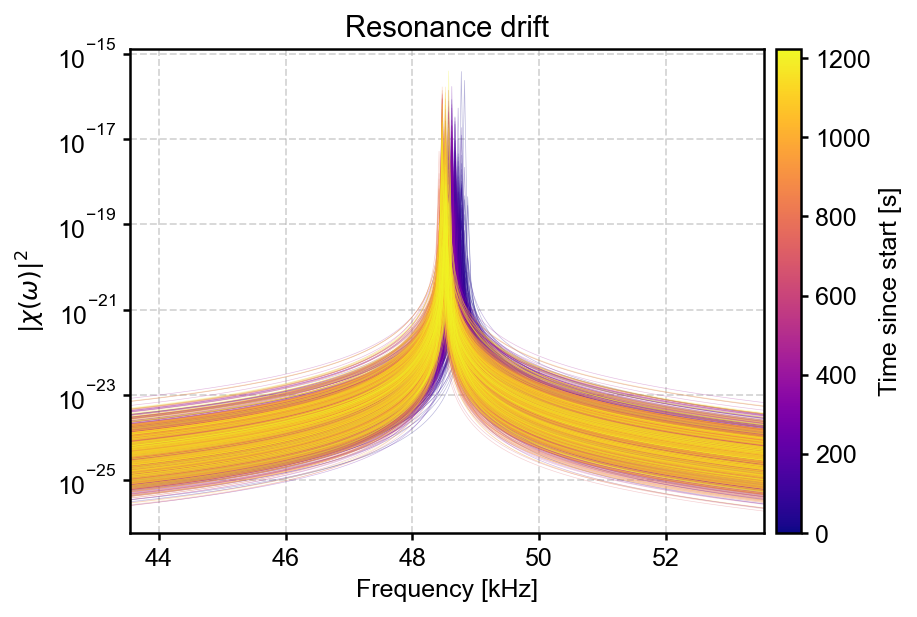

In [7]:
fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')

freq_range = np.mean(res_evol[1])/2/np.pi/1e3 + np.array((-5, 5))

omegas = 2*np.pi*1e3*np.linspace(np.amin(freq_range), np.amax(freq_range), 200)
colors = [plt.get_cmap('plasma', res_evol.shape[1])(i) for i in range(res_evol.shape[1])]

for i, params in enumerate(res_evol.T):
    ax.plot(1e-3*omegas/2/np.pi, dp.abs_susc2(omegas, *params), alpha=0.3, lw=0.3, color=colors[i])

ax.set_yscale('log')
ax.set_xlabel('Frequency [kHz]')
ax.set_xlim(freq_range)
ax.set_ylabel(r'$|\chi(\omega)|^2$')
ax.set_title('Resonance drift')
ax.grid()
fig.colorbar(ScalarMappable(norm=Normalize(0, np.amax(res_times)), cmap='plasma'), ax=ax, label='Time since start [s]', pad=0.02)
if plot_path:
    fig.savefig(plot_path + '_res_drift.pdf')

### Look at the average waveform for each impulse magnitude

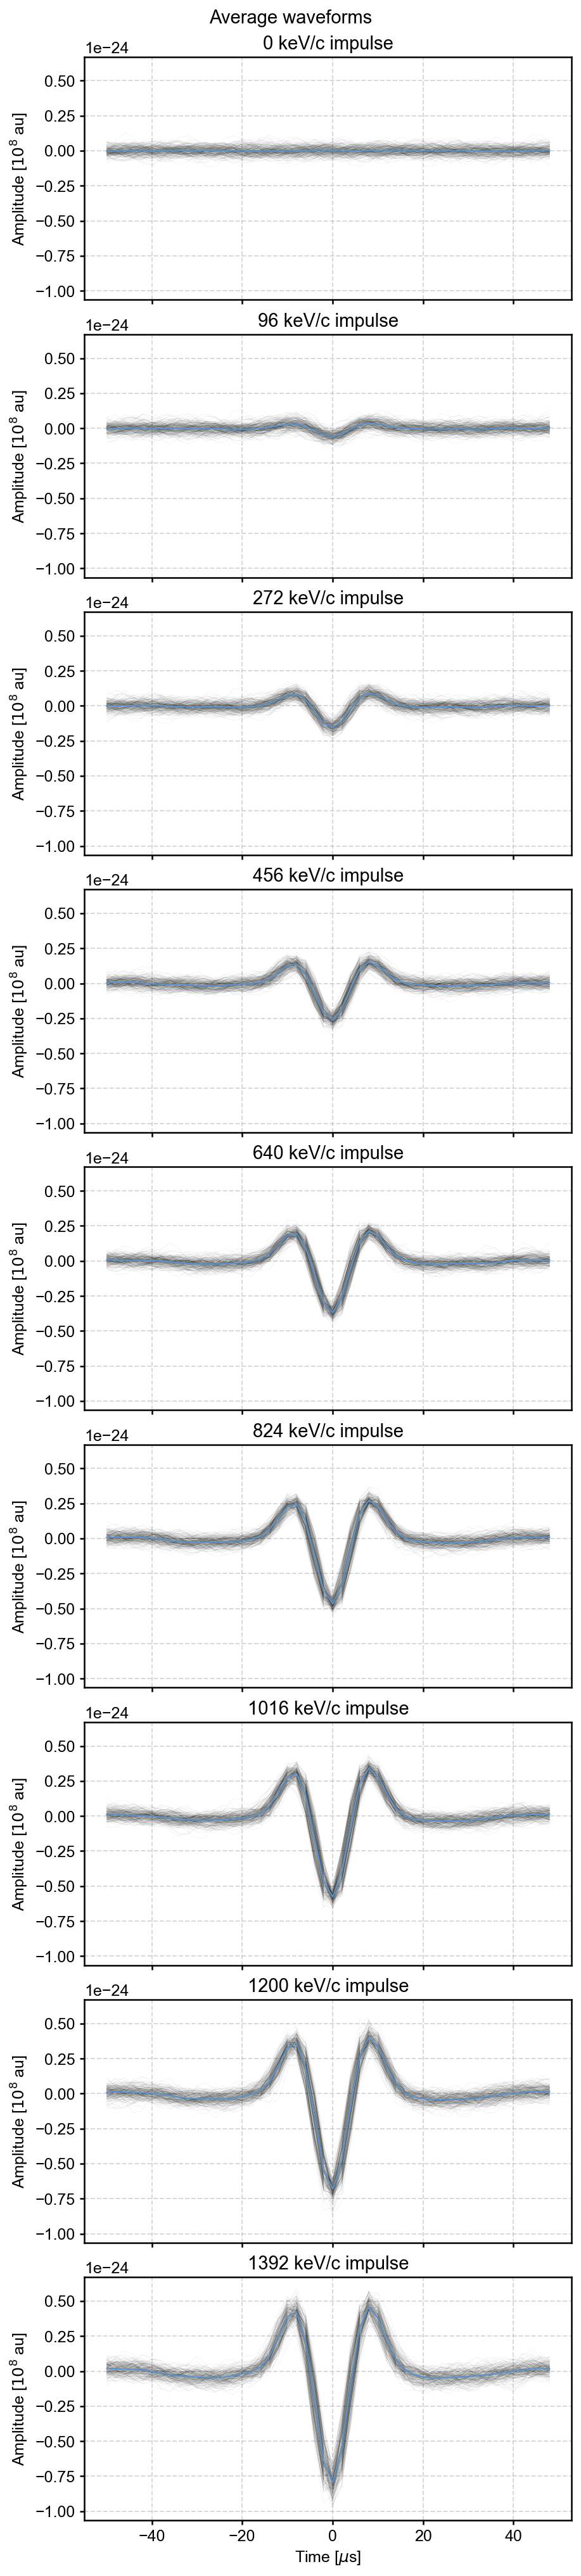

In [8]:
# build a time array
half_window = 25
peak_ind = np.argmax(np.abs(np.mean(pulses[-1], axis=0)))
times = np.arange(0, pulses.shape[-1]/2./freqs[-1], 1./2./freqs[-1])
times -= times[peak_ind]
time_slice = times[..., peak_ind - half_window:peak_ind + half_window]

# get the cropped waveforms centered around the true impulse time
pulses_true_imp = np.copy(pulses[..., peak_ind - half_window:peak_ind + half_window])
pulses_true_imp[~mask] = np.nan
mean_pulses_true_imp = np.nanmean(pulses_true_imp, axis=1)

# get the cropped waveforms centered around the reconstructed impulse time
# offsets = np.arange(2*half_window) - half_window
# time_inds = recon_inds[..., None] + offsets
# pulses_recon_imp = np.take_along_axis(pulses, time_inds, axis=2)
# mean_pulses_recon_imp = np.mean(pulses_recon_imp, axis=1)

fig, ax = plt.subplots(mean_pulses_true_imp.shape[0], figsize=(6, 3*mean_pulses_true_imp.shape[0]), \
                       sharex=True, sharey=True, layout='constrained')
for i in range(mean_pulses_true_imp.shape[0]):
    ax[i].plot(time_slice*1e6, pulses_true_imp[i].T*1e-8, lw=0.2, alpha=0.1, color='k')
    ax[i].plot(time_slice*1e6, mean_pulses_true_imp[i]*1e-8)
    ax[i].set_ylabel('Amplitude [$10^8$ au]')
    ax[i].set_title('{:.0f} keV/c impulse'.format(pulse_amps_keV[i]))
    ax[i].grid(which='both')
ax[-1].set_xlabel(r'Time [$\mu$s]')
fig.suptitle('Average waveforms')
if plot_path:
    fig.savefig(plot_path + 'avg_wfms_uncal.pdf')

### Calibrate to the known impulses

0 keV/c impulse:	 27.9 keV resolution
96 keV/c impulse:	 36.9 keV resolution
272 keV/c impulse:	 54.4 keV resolution
456 keV/c impulse:	 57.5 keV resolution
640 keV/c impulse:	 53.7 keV resolution
824 keV/c impulse:	 59.0 keV resolution
1016 keV/c impulse:	 54.5 keV resolution
1200 keV/c impulse:	 70.7 keV resolution
1392 keV/c impulse:	 125.4 keV resolution
----------------------------------------------
Mean resolution:	 67.9 keV


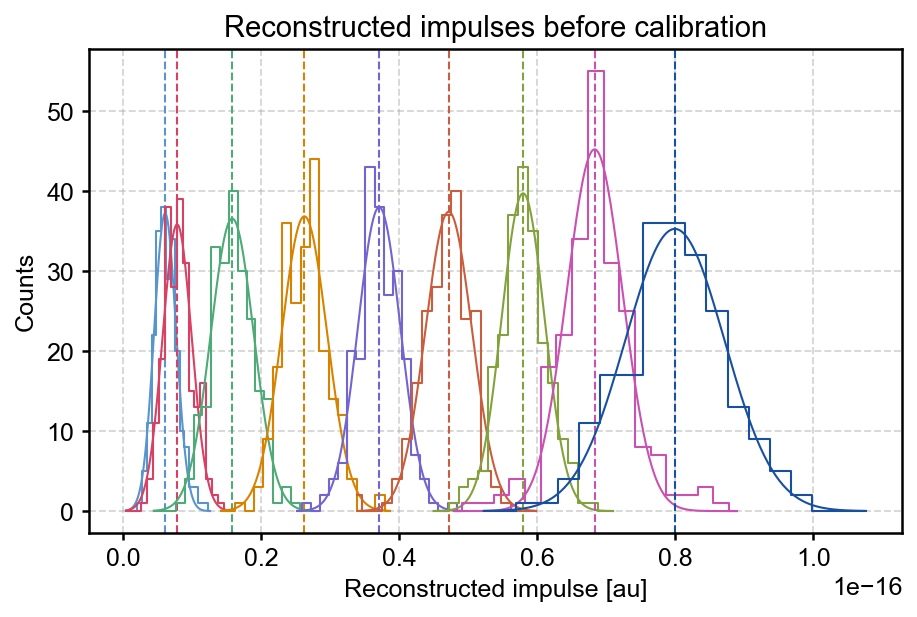

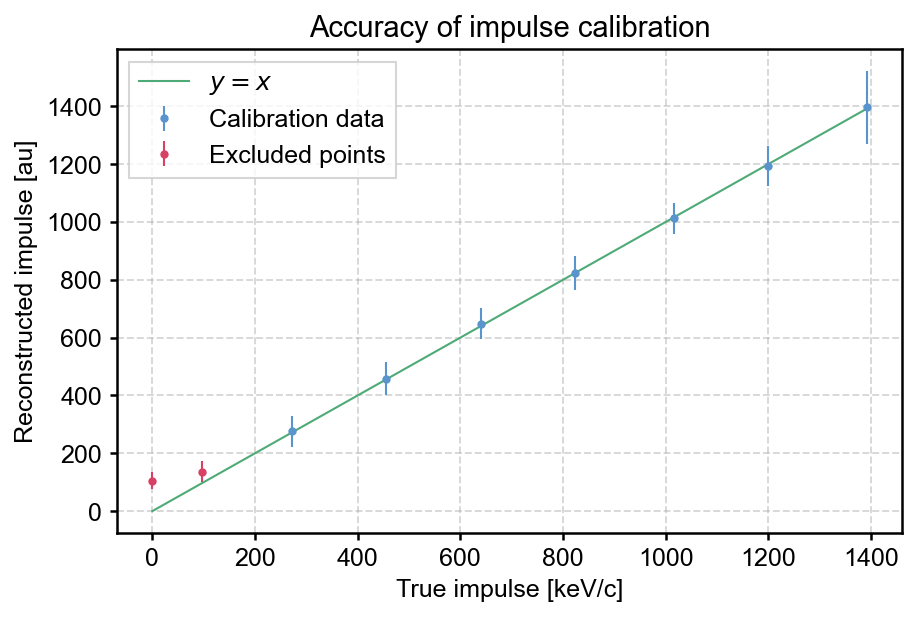

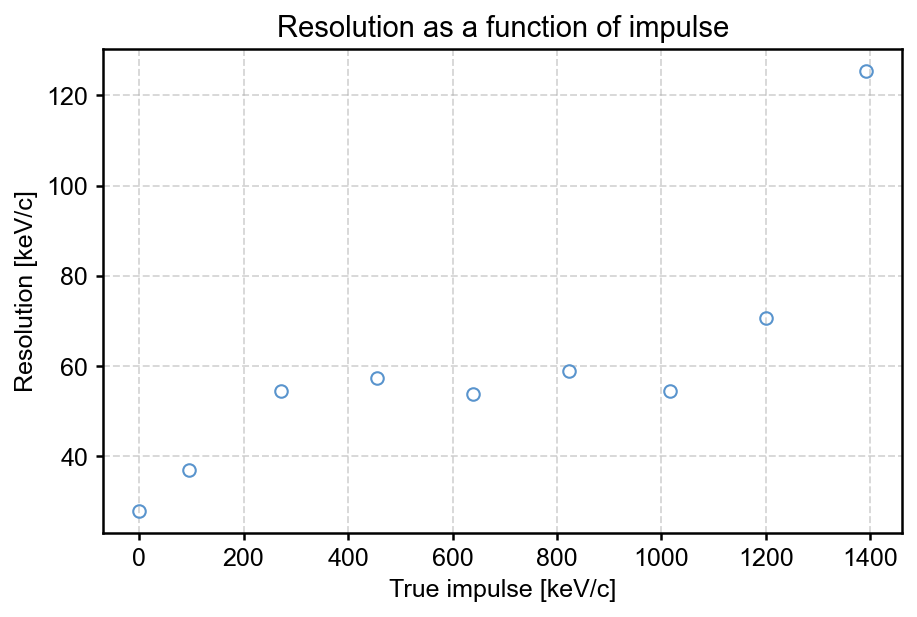

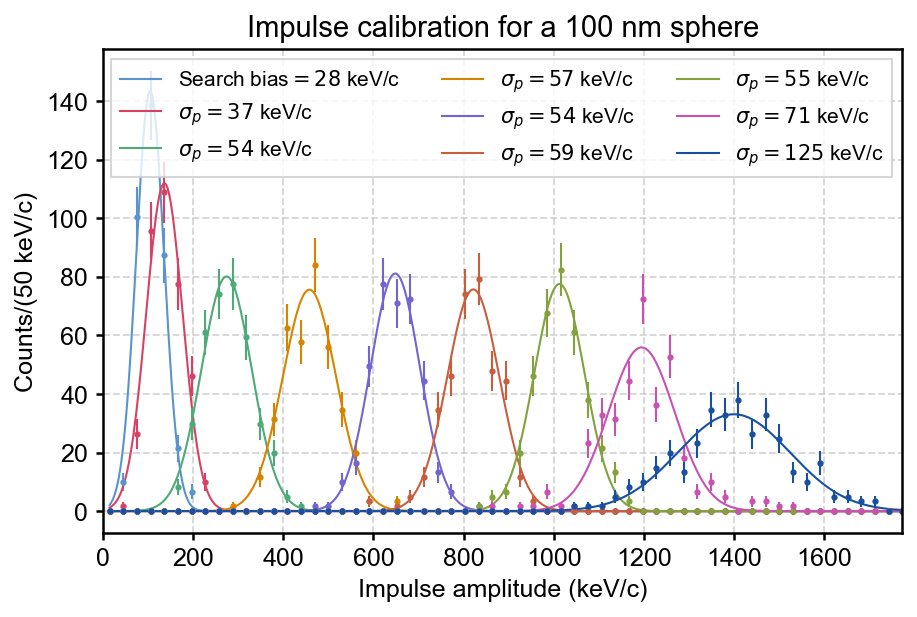

In [9]:
def gaus(x, A, mu, sigma):
    """Gaussian function.
    """
    return A*np.exp(-(x - mu)**2/2/sigma**2)

def slope(x, y, sigma=1):
    """Analytic form of the best-fit slope to two
    series of data.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    sigma = np.asarray(sigma)

    w = 1.0 / sigma**2
    denom = np.sum(w * x**2)
    if denom == 0:
        raise ValueError("Degenerate x values; slope is undefined.")

    return np.sum(w * x * y) / denom

means = []
errs = []

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
for i, imp_all in enumerate(impulses):
    imp = imp_all[mask[i]]
    mean = np.mean(np.abs(imp))
    std = np.std(np.abs(imp))
    counts, bins = np.histogram(np.abs(imp), bins=np.linspace(np.amax((0, mean - 4*std)), mean + 4*std, 20))
    bins = (bins[:-1] + bins[1:])/2.
    p, _ = curve_fit(gaus, bins, counts, p0=(10, np.mean(np.abs(imp)), np.std(np.abs(imp))))
    plot_bins = np.linspace(bins[0], bins[-1], 200)
    ax.step(bins, counts, color='C' + str(i), where='mid')
    ax.plot(plot_bins, gaus(plot_bins, *p), color='C' + str(i))
    means.append(p[1])
    errs.append(np.abs(p[2]))
    ax.axvline(p[1], ls='--', color='C' + str(i))
ax.set_xlabel('Reconstructed impulse [au]')
ax.set_ylabel('Counts')
# ax.set_xlim([0, 250])
ax.set_title('Reconstructed impulses before calibration')
ax.grid()
if plot_path:
    fig.savefig(plot_path + '_recon_uncal.pdf')

means = np.array(means)
errs = np.array(errs)

exclude_first = 2 # how many of the first datasets to exclude from the calibration line fit

# compute the scaling from Newtons to keV/c
to_keV = 1./slope(pulse_amps_keV[exclude_first:], means[exclude_first:], errs[exclude_first:])

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
plot_amps = np.linspace(0, np.amax(pulse_amps_keV), 2)
ax.errorbar(pulse_amps_keV[exclude_first:], to_keV*means[exclude_first:], \
            to_keV*errs[exclude_first:], marker='.', ls='none', label='Calibration data')
ax.errorbar(pulse_amps_keV[:exclude_first], to_keV*means[:exclude_first], \
            to_keV*errs[:exclude_first], marker='.', ls='none', label='Excluded points')
ax.plot(plot_amps, plot_amps, label='$y=x$')
ax.set_xlabel('True impulse [keV/c]')
ax.set_ylabel('Reconstructed impulse [au]')
ax.set_title('Accuracy of impulse calibration')
ax.legend()
ax.grid()
if plot_path:
    fig.savefig(plot_path + '_calibration.pdf')

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
ax.plot(pulse_amps_keV, to_keV*errs, marker='o', ls='none', fillstyle='none')
ax.set_xlabel('True impulse [keV/c]')
ax.set_ylabel('Resolution [keV/c]')
ax.set_title('Resolution as a function of impulse')
ax.grid()
if plot_path:
    fig.savefig(plot_path + '_resolution.pdf')

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
for i, imp_all in enumerate(impulses):
    imp = imp_all[mask[i]]
    if i == 0:
        label = 'Search bias$={:.0f}$ keV/c'.format(errs[i]*to_keV)
    else:
        label = '$\\sigma_p = {:.0f}$ keV/c'.format(errs[i]*to_keV)
    imp_cal = np.abs(imp)*to_keV #- cal_params[1]/cal_params[0]
    counts, bins = np.histogram(imp_cal, bins=np.linspace(0, 3000, 100))
    counts = counts * 50/(bins[1] - bins[0])
    bins = (bins[:-1] + bins[1:])/2.
    p0 = (100, np.mean(imp_cal), np.std(imp_cal))
    try:
        p, _ = curve_fit(gaus, bins, counts, p0=p0)
    except RuntimeError:
        p = p0
    plot_bins = np.linspace(bins[0], bins[-1], 1000)
    # ax.step(bins, counts, color='C' + str(i - 1), alpha=0.5, where='mid')
    ax.errorbar(bins, counts, np.sqrt(counts), color='C' + str(i), ls='none', marker='.', ms=4)
    ax.plot(plot_bins, gaus(plot_bins, *p), color='C' + str(i), label=label)
ax.set_xlim([0, means[-1]*to_keV + 3*errs[-1]*to_keV])
ax.set_xlabel('Impulse amplitude (keV/c)')
ax.set_ylabel('Counts/(50 keV/c)')
ax.grid()
ax.legend(ncol=len(impulses)//3, fontsize=10)
ax.set_title('Reconstructed impulses after calibration')
ax.set_title(f'Impulse calibration for a {config['d_sphere_nm']:.0f} nm sphere')
fig.savefig('resolution_100nm.pdf')
if plot_path:
    fig.savefig(plot_path + '_recon_cal.pdf')

resolutions = errs*to_keV
for pulse, res in zip(pulse_amps_keV, resolutions):
    print('{:.0f} keV/c impulse:\t {:.1f} keV resolution'.format(pulse, res))

print('----------------------------------------------')
print('Mean resolution:\t {:.1f} keV'.format(np.mean(resolutions[2:])))

### Show calibrated waveforms

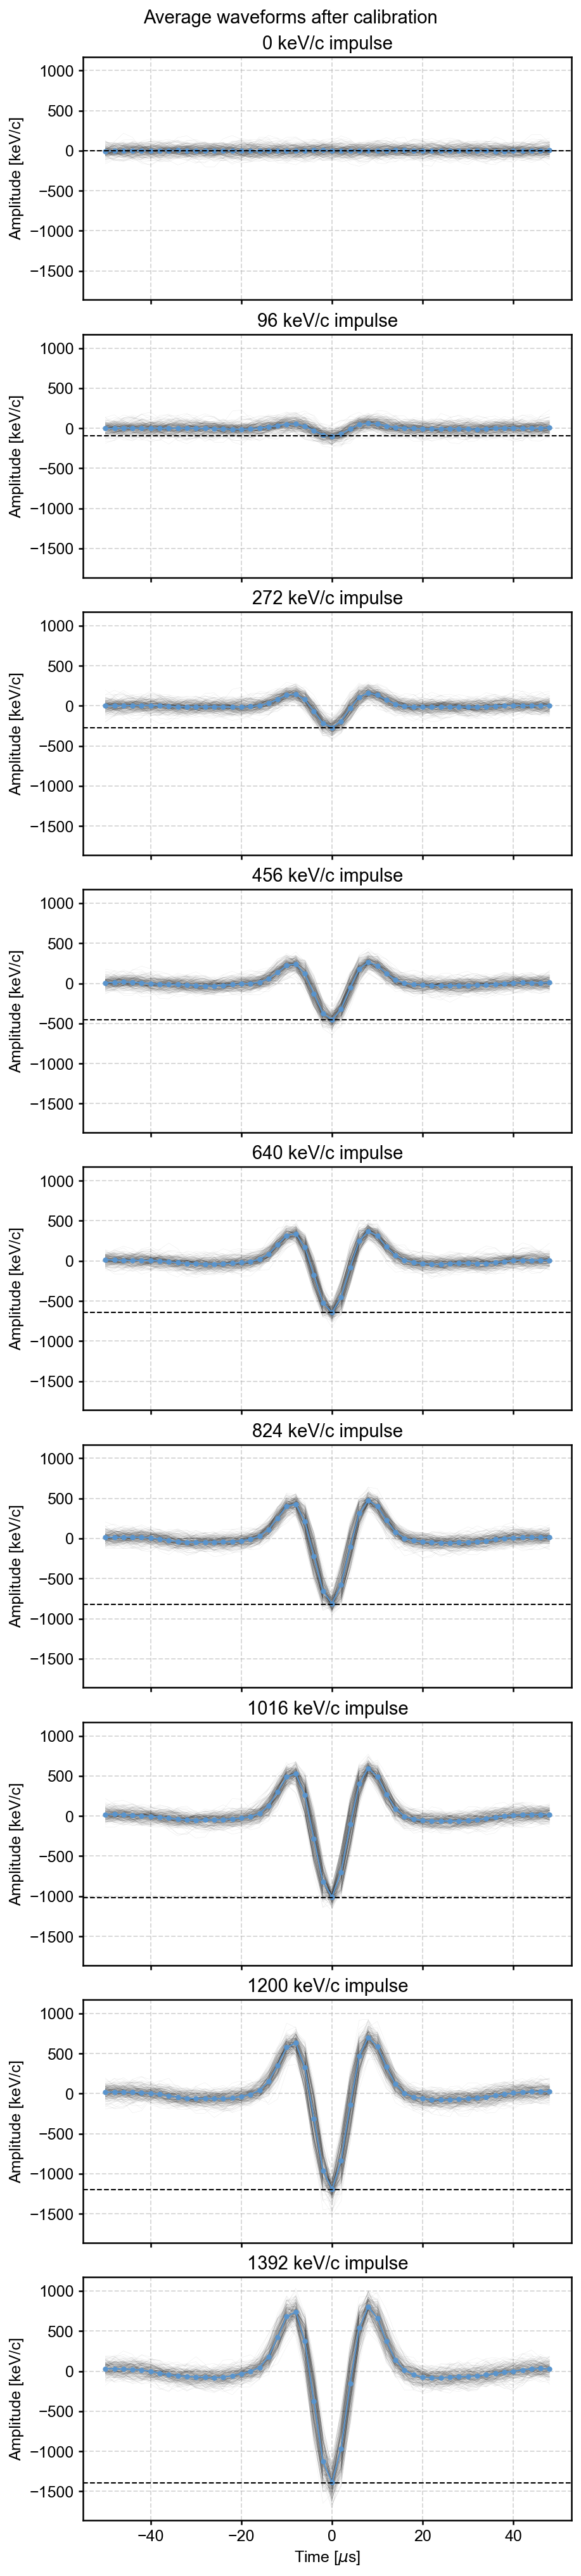

In [10]:
fig, ax = plt.subplots(mean_pulses_true_imp.shape[0], figsize=(6, 3*mean_pulses_true_imp.shape[0]), \
                       sharex=True, sharey=True, layout='constrained')
for i in range(mean_pulses_true_imp.shape[0]):
    ax[i].plot(time_slice*1e6, to_keV*pulses_true_imp[i].T, lw=0.2, alpha=0.1, color='k')
    ax[i].plot(time_slice*1e6, to_keV*mean_pulses_true_imp[i], marker='.')
    ax[i].axhline(-pulse_amps_keV[i], color='k', ls='--')
    ax[i].set_ylabel('Amplitude [keV/c]')
    ax[i].set_title('{:.0f} keV/c impulse'.format(pulse_amps_keV[i]))
    ax[i].grid(which='both')
ax[-1].set_xlabel(r'Time [$\mu$s]')
fig.suptitle('Average waveforms after calibration')
if plot_path:
    fig.savefig(plot_path + 'avg_wfms_cal.pdf')

### See how pulse shape changes with amplitude

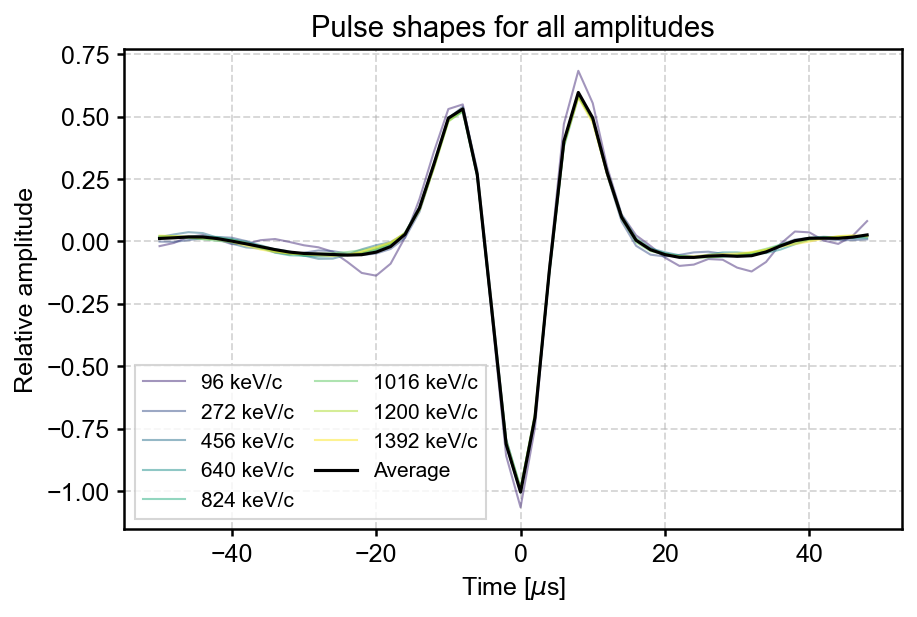

In [11]:
colors = [plt.get_cmap('viridis',len(pulse_amps_keV))(i) for i in range(len(pulse_amps_keV))]

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
for i, mp in enumerate(mean_pulses_true_imp):
    if i == 0:
        continue
    ax.plot(time_slice*1e6, to_keV*mp/pulse_amps_keV[i], alpha=0.5, color=colors[i], label='{:.0f} keV/c'.format(pulse_amps_keV[i]))
ax.plot(time_slice*1e6, np.mean(to_keV*mean_pulses_true_imp[1:]/pulse_amps_keV[1:, None], axis=0), color='k', lw=1.5, label='Average')
ax.set_xlabel(r'Time [$\mu$s]')
ax.set_ylabel('Relative amplitude')
ax.set_title('Pulse shapes for all amplitudes')
ax.legend(ncol=len(pulse_amps_keV)//4, columnspacing=1., fontsize=10)
ax.grid(which='both')

pulse_1_keV = -to_keV*mean_pulses_true_imp[-1]/pulse_amps_keV[-1]

### Look for an amplitude dependence on goodness of fit

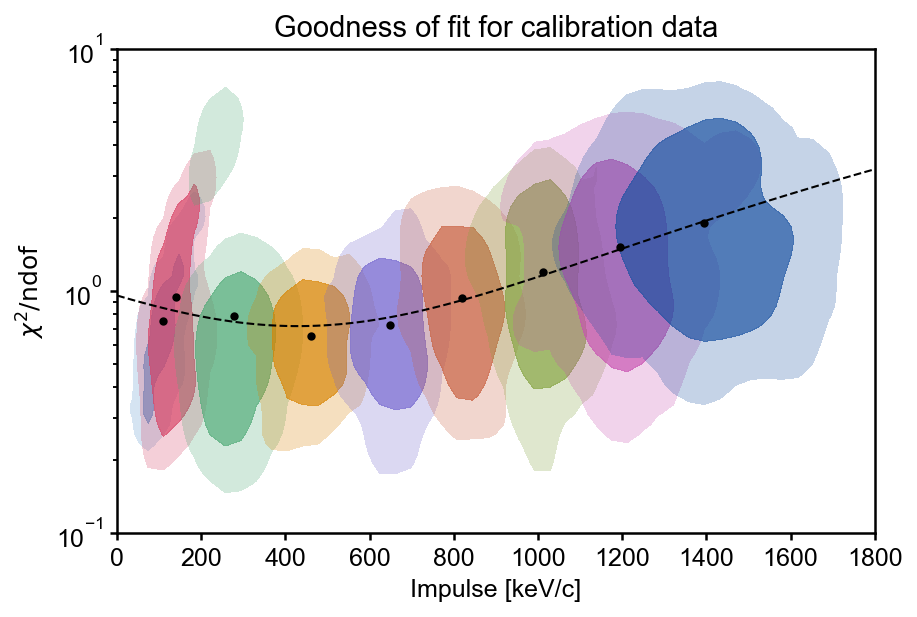

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')

ndof = len(pulse_1_keV) - 1
resolution = np.sqrt(np.mean(resolutions[2:]**2))

# Global grid so contours are comparable across iterations
x_min, x_max = 0, 1800
y_min, y_max = 1e-1, 1e1
nx, ny = 50, 50

xc = np.linspace(x_min, x_max, nx)
yc_log = np.linspace(np.log10(y_min), np.log10(y_max), ny)
X, YLOG = np.meshgrid(xc, yc_log)

xvals, yvals = [], []

for i, (pu, im) in enumerate(zip(pulses_true_imp, impulses)):
    chi2 = np.nansum(
        (to_keV * pu - to_keV * im[:, None] * pulse_1_keV[None, :])**2
        / resolution**2,
        axis=1,
    )

    x = to_keV * np.abs(im)
    y = chi2 / ndof

    xvals.append(np.mean(x))
    yvals.append(np.mean(y))

    # Filter invalid points (avoid -inf in log)
    m = np.isfinite(x) & np.isfinite(y) & (y > 0)
    x = x[m]
    y = y[m]
    if x.size < 20:
        continue

    logy = np.log10(y)

    # 2D KDE in (x, log10(y))
    data = np.vstack([x, logy])
    kde = stats.gaussian_kde(data, bw_method="scott")  # or e.g. 0.3 / "silverman"

    # Evaluate KDE on the grid
    grid = np.vstack([X.ravel(), YLOG.ravel()])
    Z = kde(grid).reshape(YLOG.shape)

    # Convert KDE to an approximate PDF over the grid for enclosed-probability contours
    dx = xc[1] - xc[0]
    dy = yc_log[1] - yc_log[0]
    pdf = Z * dx * dy

    pdf_flat = pdf.ravel()
    if not np.any(pdf_flat > 0):
        continue

    idx = np.argsort(pdf_flat)[::-1]
    cdf = np.cumsum(pdf_flat[idx])

    # Levels corresponding to 68% and 95% enclosed probability (HDR contours)
    levels_pdf = []
    for frac in (0.68, 0.95):
        j = min(np.searchsorted(cdf, frac), len(idx) - 1)
        levels_pdf.append(pdf_flat[idx][j])

    l1, l2 = sorted(levels_pdf)           # increasing for contour/contourf
    levels_fill = [l1, l2, pdf.max()]     # fill 2σ ring + 1σ core

    # Plot in original y (log axis)
    Y = 10**YLOG

    ax.contourf(
        X, Y, pdf,
        levels=levels_fill,
        colors=[f"C{i}", f"C{i}"],
        alpha=[0.25, 0.75],
    )

xvals = np.asarray(xvals)
yvals = np.asarray(yvals)

def quad(x, a, b, c):
    return a*x**2 + b*x + c

p, _ = curve_fit(quad, xvals, yvals)

xplot = np.linspace(x_min, x_max, 100)

ax.plot(xvals, yvals, color='k', ls='none', marker='.')
ax.plot(xplot, quad(xplot, *p), '--k')

ax.set_yscale("log")
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_xlabel("Impulse [keV/c]")
ax.set_ylabel(r"$\chi^2 / \mathrm{ndof}$")
ax.set_title('Goodness of fit for calibration data')
if plot_path:
    fig.savefig(plot_path + '_chi2_vs_imp.pdf')

### Add the calibration parameters to the config file

In [29]:
config['keV_per_N'] = float(to_keV)
config['template'] = [float(i) for i in pulse_1_keV]
config['resolution'] = float(resolution)
config['meters_per_volt'] = float(meters_per_volt)

config_path = 'configs/' + base_path.split('pulse_calibration/')[-1] + dataset
os.makedirs(config_path, exist_ok=True)

with open(config_path + '/config.yaml', 'w') as f:
    yaml.safe_dump(config, f)